### Experiment Protocols

Subjects rested on a tilt table with foot support and subsequently underwent a series of six changes in posture: 
- Two stand-ups, (= 6 min)
- Two rapid HUTs (75◦ HUT over 2 secs), and (= 6 min)
- Two slow HUTs (75◦ HUT over 50 secs) (= 6 min)
- Each lasting for three minutes and separated by five minutes in the resting supine position.
- The sequence of six interventions was randomized for each subject.
- At the conclusion of the final intervention, the subject was returned to the horizontal position for a final five minutes of   supine baseline recording.

For six postural changes:
- Rest -> PC -> Rest -> PC -> Rest -> PC -> Rest -> PC -> Rest -> PC -> Rest -> PC -> Rest ( atleast 35 + 18 = 53 min of data)
#### The data is interpolated for the first 2 protocols

In [1]:
%matplotlib inline
import os
import math

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

from LaguerreCalc import phi_j, l_j, lagl_j # call laguerre related functions from .py file

import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ECG processing libraries
import scipy.signal 
import peakutils
import heartpy as hp
import wfdb
from wfdb import processing


#### Value of constants

In [2]:
alpha = .2
J = 9
N1 = 2
N2 = 7
W_n = 90

num_parameters = 10
forgetting_factor = .98

# Values taken from related paper
coeff_S = [39.2343, 10.1963, -5.9242] 
coeff_P = [28.4875, -17.3627, 5.8798, 12.0628, 5.6408, -7.0664, -5.6779, -3.9474]


#### Functions declared

In [3]:
def normalize(x):
    x = x - np.mean(x)
    return x/np.std(x)

#### Read one ECG recording in wfdb format

In [4]:
# Plot the signals, and show the data.
record = wfdb.rdrecord('changes-in-postureData/12726') 
#wfdb.plot_wfdb(record=record, title='Record 12726 from PhysioNet Postural Data', figsize=(12,10)) 
display(record.__dict__)

{'record_name': '12726',
 'n_sig': 3,
 'fs': 250,
 'counter_freq': 24000.0,
 'base_counter': None,
 'sig_len': 825000,
 'base_time': datetime.time(15, 8, 24),
 'base_date': None,
 'comments': ['<age>: 28  <sex>: M  <Height>: 170  <Weight>: 64',
  'Produced by xform from record 12726_orig, beginning at 0:0'],
 'sig_name': ['ABP', 'ECG', 'Angle'],
 'p_signal': array([[ 6.24804749e+01, -1.98291120e+00, -4.57587371e-02],
        [ 6.21055920e+01, -1.98962466e+00, -4.57587371e-02],
        [ 6.14807873e+01, -1.97070491e+00, -4.57587371e-02],
        ...,
        [ 8.12246173e-01,  6.10314312e-04, -1.60155580e-01],
        [ 8.12246173e-01,  6.10314312e-04, -1.60155580e-01],
        [ 8.12246173e-01,  6.10314312e-04, -1.60155580e-01]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['12726.dat', '12726.dat', '12726.dat'],
 'fmt': ['16', '16', '16'],
 'samps_per_frame': [1, 1, 1],
 'skew': [None, None, None],
 'byte_offset': [None, None, None],
 'adc_gain': [64.02

In [5]:
#Convert record into dataframe whose index is TimedeltaIndex
record_df = record.to_dataframe()
record_df

,ABP,ECG,Angle
0 days 00:00:00,62.480475,-1.982911,-0.045759
0 days 00:00:00.004000,62.105592,-1.989625,-0.045759
0 days 00:00:00.008000,61.480787,-1.970705,-0.045759
0 days 00:00:00.012000,61.168385,-1.966433,-0.045759
0 days 00:00:00.016000,60.855983,-1.979860,-0.045759
...,...,...,...
0 days 00:54:59.980000,0.812246,0.000610,-0.160156
0 days 00:54:59.984000,0.812246,0.000610,-0.160156
0 days 00:54:59.988000,0.812246,0.000610,-0.160156
0 days 00:54:59.992000,0.812246,0.000610,-0.160156


In [6]:
# ECG data is saved in an array
# ecg_data = record.p_signal[:,1]
ecg_df = pd.DataFrame(record_df.iloc[:,1])
angle_df = pd.DataFrame(record_df.iloc[:,2])


#### Working with angle_data

In [7]:
angle_df.head()

,Angle
0 days 00:00:00,-0.045759
0 days 00:00:00.004000,-0.045759
0 days 00:00:00.008000,-0.045759
0 days 00:00:00.012000,-0.045759
0 days 00:00:00.016000,-0.045759


#### Working with ECG data

In [8]:
# ecg_data
ecg_df

,ECG
0 days 00:00:00,-1.982911
0 days 00:00:00.004000,-1.989625
0 days 00:00:00.008000,-1.970705
0 days 00:00:00.012000,-1.966433
0 days 00:00:00.016000,-1.979860
...,...
0 days 00:54:59.980000,0.000610
0 days 00:54:59.984000,0.000610
0 days 00:54:59.988000,0.000610
0 days 00:54:59.992000,0.000610


In [9]:
# using heartpy.process, wd = working_data dict in which results are stored, measures(m): measures dict in which results are stored
wd_band, m_band = hp.process(ecg_df['ECG'], sample_rate = record.fs)


In [10]:
wd_band['peaklist'][-1]


812857

In [11]:
# number of RR peaks
len(wd_band['peaklist'])

3800

#### Find rr interval using 'peaklist' from 'wd'

In [12]:
t = np.arange(0, len(ecg_df))/250

# Finding RR interval
RR = np.diff(t[wd_band["peaklist"]])
print(len(RR))

3799


In [14]:
HR = 60/RR

print(HR, len(HR))

[60.72874494 59.52380952 63.55932203 ... 60.24096386 54.94505495
 73.89162562] 3799


In [15]:
print('max HR is', max(HR), ' and min HR is', min(HR),'. The average HR is', np.average(HR))

max HR is 15000.000000354703  and min HR is 7.763975155279551 . The average HR is 300.4189697516254


#### Finding angle value at the peaks

In [16]:
peak_angle = angle_df['Angle'][wd_band['peaklist']].reset_index().drop(columns=['index'])
print(peak_angle)
print(type(peak_angle))

         Angle
0    -0.045759
1    -0.045759
2    -0.045759
3    -0.045759
4    -0.045759
...        ...
3795  0.068638
3796  0.068638
3797  0.068638
3798  0.068638
3799  0.068638

[3800 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


In [17]:
time_df = t[wd_band["peaklist"]]
time_df

RR_df = pd.DataFrame(RR, time_df[1:]).reset_index().rename(columns={'index':'beats', 0:'RR'})
RR_df['angle_peaks'] = peak_angle
#RR_df['timestamp_peaks'] = timestamp_peaks
RR_df

,beats,RR,angle_peaks
0,1.232,0.988,-0.045759
1,2.240,1.008,-0.045759
2,3.184,0.944,-0.045759
3,4.168,0.984,-0.045759
4,5.152,0.984,-0.045759
...,...,...,...
3794,3247.488,1.020,0.068638
3795,3248.528,1.040,0.068638
3796,3249.524,0.996,0.068638
3797,3250.616,1.092,0.068638


### Resampling each segment of posture change

In [18]:
peaks,  props= find_peaks(np.round(RR_df['angle_peaks']), width=3, height=[73,76], plateau_size = 3)
props

{'plateau_sizes': array([245, 245, 228, 188], dtype=int64),
 'left_edges': array([ 422, 1099, 2921, 3430], dtype=int64),
 'right_edges': array([ 666, 1343, 3148, 3617], dtype=int64),
 'peak_heights': array([74., 75., 74., 75.]),
 'prominences': array([74., 75., 74., 75.]),
 'left_bases': array([ 365, 1096, 2865, 3427], dtype=int64),
 'right_bases': array([ 724, 1348, 3212, 3622], dtype=int64),
 'widths': array([296.        , 247.50551783, 283.        , 190.19447674]),
 'width_heights': array([37. , 37.5, 37. , 37.5]),
 'left_ips': array([ 396.        , 1097.11290323, 2895.        , 3428.2125    ]),
 'right_ips': array([ 692.        , 1344.61842105, 3178.        , 3618.40697674])}

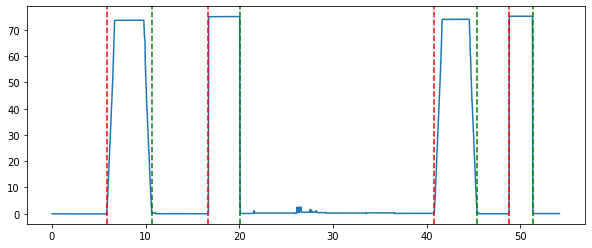

In [19]:
fig, ax = plt.subplots(1,1,figsize = (10,4))

ax.plot(RR_df['beats']/60, RR_df['angle_peaks'])
for i,j in zip(props['left_bases'], props['right_bases']):
    ax.axvline(x=RR_df['beats'][i]/60, color='red', ls='--')
    ax.axvline(x=RR_df['beats'][j]/60, color='green', linestyle='--')

#### Segmenting the data based on inflexion point using the indices given by 'right_bases' and 'left_bases'

In [20]:
rest1 = RR_df.iloc[:props['left_bases'][0]+1, :]
slant1 = RR_df.iloc[props['left_bases'][0]+1:props['right_bases'][0]+1, :]
rest2 = RR_df.iloc[props['right_bases'][0]+1:props['left_bases'][1]+1, :]
vpeak1 = RR_df.iloc[props['left_bases'][1]:props['right_bases'][1]+1, :]

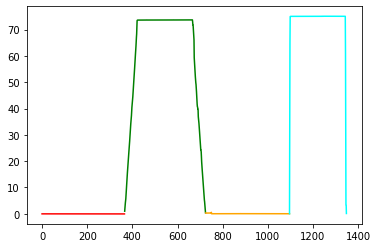

In [21]:
plt.plot(rest1['angle_peaks'], color='red')
plt.plot(slant1['angle_peaks'], color='green')
plt.plot(rest2['angle_peaks'], color='orange')
plt.plot(vpeak1['angle_peaks'], color='cyan')

In [22]:
# finding the timepoints after dividing each segment in 1/250 step size
tstep = 1/250
dt_r1 = np.arange(rest1['beats'].iloc[0], rest1['beats'].iloc[-1], tstep)
dt_s1 = np.arange(slant1['beats'].iloc[0], slant1['beats'].iloc[-1]-tstep, tstep)
dt_r2 = np.arange(rest2['beats'].iloc[0], rest2['beats'].iloc[-1]-tstep, tstep)
dt_vp1 = np.arange(vpeak1['beats'].iloc[0], vpeak1['beats'].iloc[-1]-tstep, tstep)


In [23]:
# Interpolate the data using nearest neighbor interpolation
f1 = interp1d(rest1['beats'], rest1['RR'], kind='nearest')
f2 = interp1d(slant1['beats'], slant1['RR'], kind='nearest')
f3 = interp1d(rest2['beats'], rest2['RR'], kind='nearest')
f4 = interp1d(vpeak1['beats'], vpeak1['RR'], kind='nearest')


#Calculate the interpolated RR value 
interpolated_r1 = pd.DataFrame(f1(dt_r1), dt_r1).reset_index()
interpolated_s1 = pd.DataFrame(f2(dt_s1), dt_s1 ).reset_index()
interpolated_r2 = pd.DataFrame(f3(dt_r2), dt_r2).reset_index()
interpolated_vp1 = pd.DataFrame(f4(dt_vp1), dt_vp1).reset_index()

#### Combine the segments - rest1, slant1, rest2, vpeak1

In [24]:
frames = [interpolated_r1, interpolated_s1, interpolated_r2, interpolated_vp1]
RR_df_new = pd.concat(frames).rename(columns={'index':'int_beats', 0:'int_RR'}).reset_index()
RR_df_new

,index,int_beats,int_RR
0,0,1.232,0.988
1,1,1.236,0.988
2,2,1.240,0.988
3,3,1.244,0.988
4,4,1.248,0.988
...,...,...,...
300809,51129,1206.388,1.520
300810,51130,1206.392,1.520
300811,51131,1206.396,1.520
300812,51132,1206.400,1.520


#### Plot actual versus interpolated data

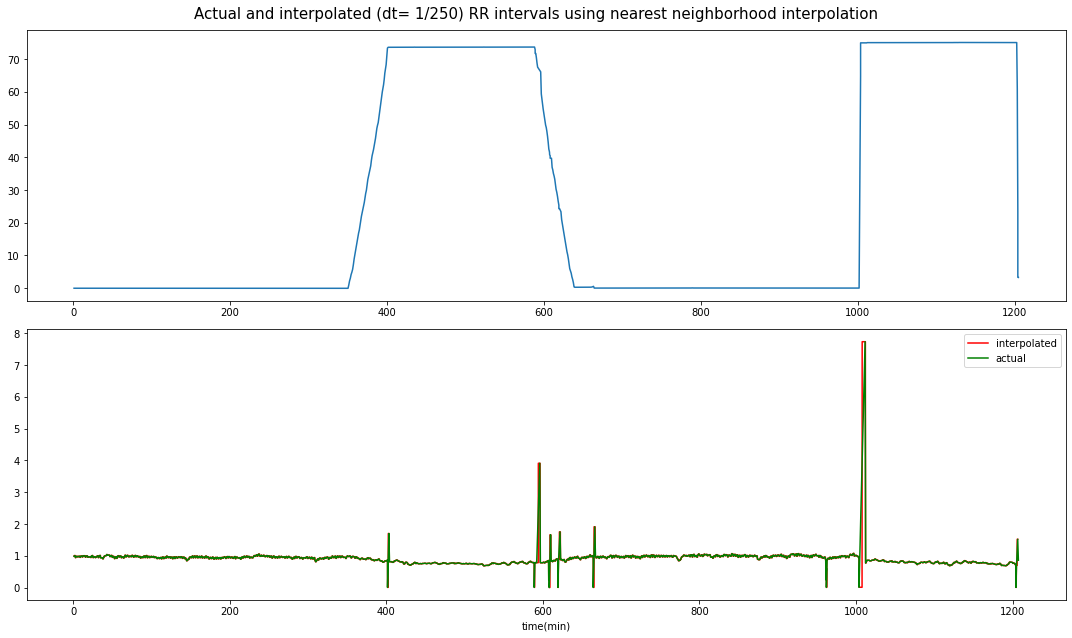

In [26]:
fig, ax = plt.subplots(2,1, figsize=(15,9))
ax[0].plot(RR_df['beats'][:props['right_bases'][1]], RR_df['angle_peaks'][:props['right_bases'][1]])
ax[1].plot(RR_df_new['int_beats'], RR_df_new['int_RR'], color='red', label='interpolated')
ax[1].plot(RR_df['beats'][:1350], RR_df['RR'][:1350], color='green', label='actual')
ax[1].legend()
fig.suptitle('Actual and interpolated (dt= 1/250) RR intervals using nearest neighborhood interpolation', fontsize=15)
ax[1].set_xlabel('time(min)')
fig.tight_layout()

### Calculating Laguerre polynomial of order j with time-lag (RR_intervals) n, 0<=n<=90,  0<=j<=8

In [27]:
phi_mat = np.array([[phi_j(n,j, alpha)  for j in range (J)] for n in range(1, W_n)])

### Calculating Laguerre filter output using laguerre polynomials and RR interval at time t=2 in the given window (w_n)

In [28]:
l_j(J,2, RR_df_new, W_n, alpha)

array([ 0.57193881, -1.08349644, -0.51793224,  0.00637461,  0.22240091,
        0.2482321 ,  0.20016793,  0.13950634,  0.08926919])

### Laguerre filter output at each time point

In [29]:
lagl_j = lagl_j(J, RR_df_new, W_n, alpha)

#### Convert the laguerre filter output matrix into dataframe

In [30]:
G = [f'l{j}'  for j in range(J)]
lag_df = pd.DataFrame(lagl_j, columns=G)
lag_df['RR'] = RR_df_new['int_RR']


In [31]:
lag_df.shape

(300814, 10)

In [32]:
lag_df.head()

,l0,l1,l2,l3,l4,l5,l6,l7,l8,RR
0,0.395200,-0.530216,-0.553280,-0.388825,-0.237120,-0.134321,-0.072717,-0.038176,-0.019602,0.988
1,0.571939,-1.083496,-0.517932,0.006375,0.222401,0.248232,0.200168,0.139506,0.089269,0.988
2,0.650979,-1.472322,-0.122732,0.324504,0.174977,-0.061414,-0.198826,-0.232352,-0.206024,0.988
3,0.686327,-1.709442,0.336789,0.277080,-0.185570,-0.313710,-0.180445,0.008562,0.141515,0.988
4,0.702135,-1.843763,0.719342,-0.032566,-0.437866,-0.178823,0.140394,0.241405,0.160156,0.988


#### Add a column of constant 

In [33]:
lag_df.insert(0,'const', 1 )
#lag_df

In [34]:
lag_df.iloc[1,:-1]

const    1.000000
l0       0.571939
l1      -1.083496
l2      -0.517932
l3       0.006375
l4       0.222401
l5       0.248232
l6       0.200168
l7       0.139506
l8       0.089269
Name: 1, dtype: float64

## Recursive Least Square Method implementation

In [35]:
# Initialization
theta = np.zeros((J+1,1))
phi = np.empty((1,J+1))
P = np.eye((J+1))*100

In [36]:
x = np.array([lag_df.iloc[i,:-1] for i in range(len(lag_df))])
x.shape

(300814, 10)

In [37]:
x[0]

array([ 1.        ,  0.3952    , -0.53021644, -0.55328   , -0.38882539,
       -0.23712   , -0.1343215 , -0.0727168 , -0.03817558, -0.01960192])

In [38]:
y = lag_df['RR']
y.shape

(300814,)

### Calculate the indices for widow size 90 and forgetting factor .98

In [39]:
# Implementing RLS algorithm
class RecursiveLeastSquares:
    def __init__(self, num_parameters, forgetting_factor):
        self.num_parameters = num_parameters
        self.forgetting_factor = forgetting_factor
        self.theta = np.zeros((num_parameters,1))
        self.P = np.eye(num_parameters)  # Initial covariance matrix

    def update_params(self, x, y):
        x = np.reshape(x, (self.num_parameters, 1))  # Reshape input vector
        y_hat = np.dot(np.transpose(self.theta), x)  # Predicted output


        # Calculate the gain matrix
        k = np.dot(self.P, x) / (self.forgetting_factor + np.dot(np.dot(np.transpose(x), self.P), x))

        # Update the estimated parameter 
        self.theta = self.theta + np.dot(k, (y - y_hat))

        # Update the covariance matrix
        self.P = (1 / self.forgetting_factor) * (self.P - np.dot(np.dot(k, np.transpose(x)), self.P))

    def get_parameters(self):
        return self.theta

In [40]:
# Create an instance of the RLS estimator
rls_estimator = RecursiveLeastSquares(num_parameters, forgetting_factor)
params_wn = []

# Perform recursive parameter estimation
for i in range(W_n, len(lag_df)):
#     rls_estimator = RecursiveLeastSquares(num_parameters, forgetting_factor)
    x_w_n = np.array(x[i-W_n:i])
    y_w_n = np.array(y[i-W_n:i])
    [rls_estimator.update_params(x_w_n[j], y_w_n[j]) for j in range(W_n)]
    params_wn.append(rls_estimator.get_parameters())
    #print(rls_estimator.get_parameters()) #Get the estimated parameters

In [41]:
#reduce the dimension of list elements
params_wn=np.squeeze(params_wn)
params_wn

array([[ 0.38299889,  0.18268977, -0.31259563, ..., -0.00698451,
        -0.00304987, -0.00089675],
       [ 0.39638477,  0.1913674 , -0.32194927, ...,  0.01332569,
         0.00928357,  0.00327922],
       [ 0.39672462,  0.19137315, -0.32162442, ...,  0.01002965,
         0.00659719,  0.00219587],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [57]:
print(len(params_wn))
np.isnan(params_wn)

300724


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

#### Calculate the indices

In [43]:
SAI = coeff_S[0] + np.sum(coeff_S[1:]*params_wn[:,1:3], axis=1)
PAI = coeff_P[0] + np.sum(coeff_P[1:7]*params_wn[:,4:], axis=1)

In [44]:
len(SAI)

300724

In [58]:
# fig, ax = plt.subplots(1,1,figsize = (15,5))
# import seaborn as sns

# plt.plot(RR_df_new['int_beats'][W_n:]/60, normalize(SAI), color='red', label='SAI')
# # plt.plot(RR_clean['beats'][90:]/60, normalize(PAI), color='green', label='PAI')
# # plt.plot(RR_clean['beats'][90:]/60, normalize(RR_clean['angle_peaks'][90:]), label='angle')

# # ax.legend(['SAI', 'PAI', 'Angle'])


In [47]:
# # Instantiate a second axes that shares the same x-axis
# fig, ax1 = plt.subplots(1,1, figsize=(15, 6))
# ax2 = ax1.twinx()

# ax1.plot(RR_df_new['beats'][W_n:]/60, normalize(SAI), color='red', label='SAI')
# ax1.plot(RR_df_new['beats'][W_n:]/60, normalize(PAI), color='green', label='PAI')
# ax2.plot(RR_df['beats'][W_n:]/60, RR_df['angle_peaks'][W_n:], label='angle')
# ax1.set_xlabel("time (in min)")
# ax2.set_ylabel("Angle")
# ax1.set_ylabel("Normalized values of SAI/PAI")
# ax1.legend(['SAI', 'PAI'], loc='upper left')
# ax2.legend(['Angle'])